#Toxic Comment Classification 
##Identify and classify toxic online comments

Giulia Cataldo, Bianca Cattaneo, Jacopo Signò

Dataset : https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data


## 1. Data Pre-Processing Notebook


##About Dataset

####**Content**

For this project we have been assigned a dataset containing a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The assigned labels are:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

##Overview and approach 

The goal of this project is to create a model which predicts the probability for each type of toxicity for each comment.

We decided to try to achieve this goal through the implementation of 2 different models:

- A "simple" RNN architecture, more preciselly a BLSTM (Bidirectional Long Short-Term Memory)
- A more advanced trasformer based architecture.

# Environment Preparation

In [ ]:
!pip -q install spacy

In [ ]:
import pandas as pd
import numpy as np
import spacy
import re as re
import urllib
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sn
import pickle
import keras
import tensorflow
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import Embedding, LSTM, SpatialDropout1D, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,classification_report,f1_score,recall_score
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
import matplotlib as mpl
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

mpl.style.use('ggplot')  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Loading data
df_train = pd.read_csv('/content/drive/MyDrive/text_mex_project/data/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/text_mex_project/data/test.csv')
df_test_labels = pd.read_csv('/content/drive/MyDrive/text_mex_project/data/test_labels.csv')



In the repository from where we load data, the feautures and the labels of the test dataset are stored in 2 different files. Below we merge them.

In [ ]:
# joining df_test and df_test lables based on IDs
df_test = pd.merge(df_test, df_test_labels, on="id")

# Eliminating rows which are not used for scoring
df_test.drop(df_test.loc[df_test['toxic']==-1].index, inplace=True)

df_test.shape

(63978, 8)

Now we concatenate the train set with the test set. We do this beacuse, as we'll se later, the classes are really umbalanced, and we want to be sure that both in the training and test set all the classes are rappresented in the same proportion. To do so we aggregate all the comment in a single dataset and then we will split in train and test datasets with stratification.

In [ ]:
# joining df_train and df_test
df = pd.concat([df_train, df_test], axis = 0)
df = df.reset_index(drop=True)
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Data Exploration

In [ ]:
#Looking at dataset dimension 
df.shape

(223549, 8)

In [ ]:
df.loc[0:5,:]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0


We check if there are null values

In [ ]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

We drop the 'id' column since we don't need it.

In [ ]:
df = df.drop('id', axis=1)


We check if there are "whitespace only" strings.

In [ ]:
blanks = []  # start with an empty list

# (index,label,review text)
for index,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate in df.itertuples():  # iterate over the DataFrame
    if type(comment_text)==str:            # avoid NaN values
        if comment_text.isspace():         # test 'review' for whitespace
            blanks.append(index)     # add matching index numbers to the list
        
len(blanks)

0

We check if there are duplicates.

In [ ]:
total_duplicate_comments = sum(df["comment_text"].duplicated())
print(f"There are {total_duplicate_comments} duplicate comments.")

There are 0 duplicate comments.


We create a new column named as "non_toxic" : if comment doesn't belong in any of the class then "non_toxic" will be 1, else it will be 0.

In [ ]:
df["non_toxic"] = df.iloc[:,1:6].apply(lambda x: 1 if (sum(x)==0) else 0, axis=1)
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


We count the number of occurences for each class.

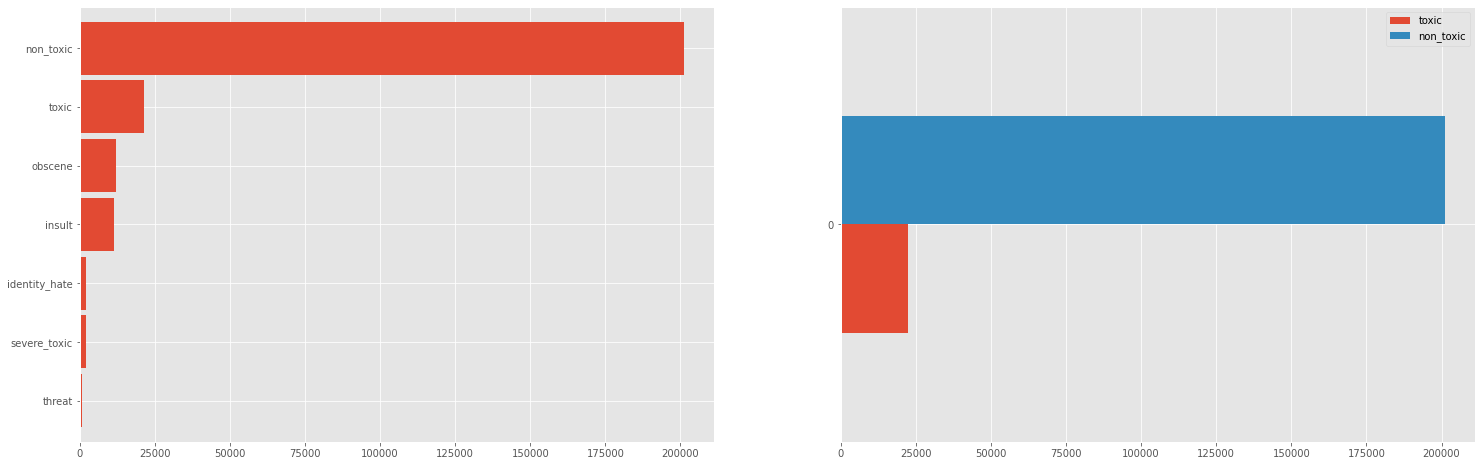

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)

col_labels = df.columns.tolist()[1:8]
df[col_labels].sum().sort_values().plot(kind="barh", ax=axes[0], figsize=(25, 8), width = 0.9)

col_labels = df.columns.tolist()[1:7]
toxic = df[df[col_labels].sum(axis=1) > 0]
nontoxic = df[df[col_labels].sum(axis=1) == 0]

pd.DataFrame(dict(
    toxic=[len(toxic)],
    non_toxic=[len(nontoxic)]
    )).plot(kind='barh', ax=axes[1], figsize=(25, 8))

plt.show()


We can easily  notice a **class imbalance** problem. 

Furthermore, we can see that we have many non-labled comments (non-toxic comments) which are not useful for toxicity classification purposes. For this reason, we decide to remove a portion of these comments.

In [ ]:
drop_indexs = np.random.choice(df[df['non_toxic']==1].index, size=193149, replace=False)

# Randomly selecting and dropping non_toxic comments from datasets 
df.drop(drop_indexs, axis = 0, inplace=True)

# resetting indexes
df = df.reset_index(drop=True)


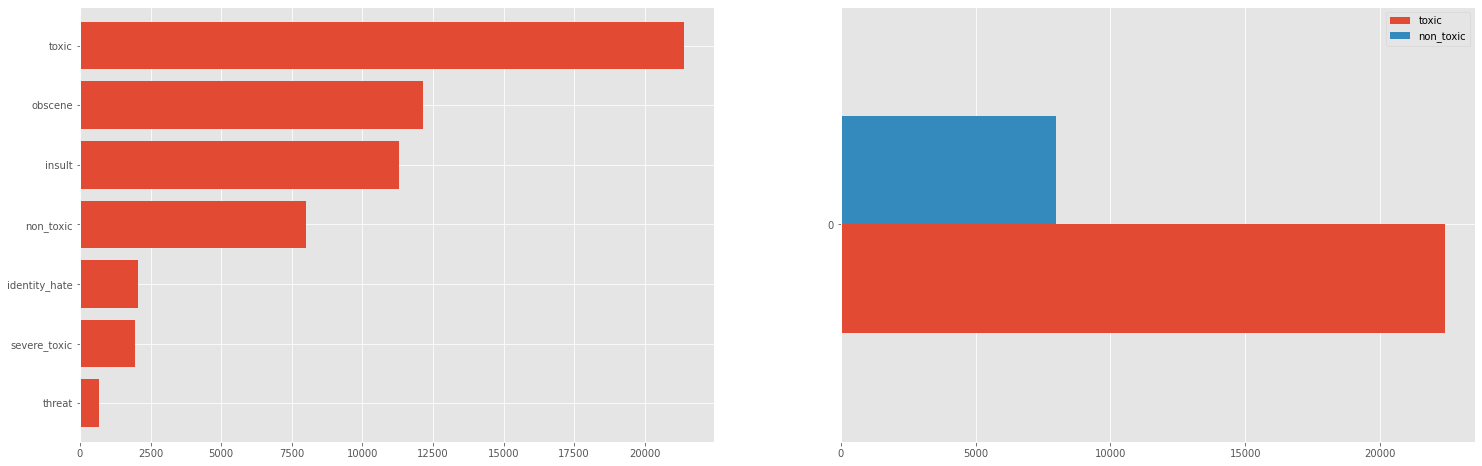

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)

col_labels = df.columns.tolist()[1:8]
df[col_labels].sum().sort_values().plot(kind="barh", ax=axes[0], figsize=(25, 8), width = 0.8)

col_labels = df.columns.tolist()[1:7]
toxic = df[df[col_labels].sum(axis=1) > 0]
nontoxic = df[df[col_labels].sum(axis=1) == 0]

pd.DataFrame(dict(
    toxic=[len(toxic)],
    non_toxic=[len(nontoxic)]
    )).plot(kind='barh', ax=axes[1], figsize=(25, 8))

plt.show()

Now toxic-labeled comments represent the majority of the comments in the dataset.

We also add a column that indicates the total number of classes each comment belongs to (this is done only for for visualization purposes) 

In [ ]:
df["total_classes"] = df.iloc[:,1:6].apply(lambda x: sum(x), axis=1)    

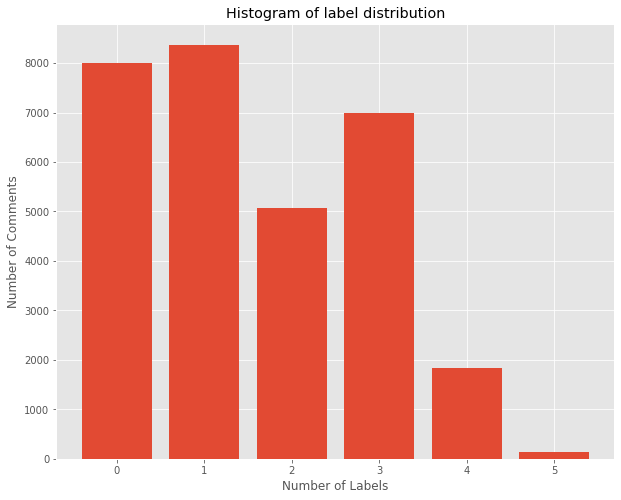

In [ ]:
labels, counts = np.unique(df['total_classes'], return_counts=True)

#df['total_classes'].plot(kind='hist', figsize=(12, 10), bins=5, xticks=bin_edges, align='mid')
plt.figure(figsize=[10,8])
x = plt.bar(labels, counts, align='center')

           
# add a title to the histogram
plt.title('Histogram of label distribution')
# add y-label
plt.ylabel('Number of Comments')
# add x-label
plt.xlabel('Number of Labels')



plt.show()

We now add a 'y' column where we insert a string of 0s and 1s, made from the concatenation of all the labels of each comment.

In [ ]:
for col in df.columns[1:]:
  df[col] = df[col].astype(str)

df['y'] = df[df.columns[1:7]].apply(lambda x: ','.join(x),axis=1)

df.head(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,total_classes,y
0,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,0,"0,0,0,0,0,0"
1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0,4,"1,1,1,0,1,0"
2,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,0,1,"1,0,0,0,0,0"
3,"Oh, and the girl above started her arguments w...",0,0,0,0,0,0,1,0,"0,0,0,0,0,0"
4,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,0,1,"1,0,0,0,0,0"


We make a pie chart to see which are the **most common combinations** of labels.

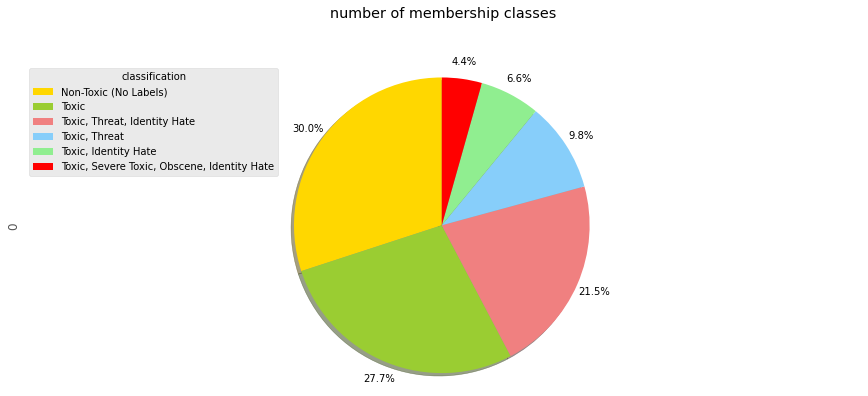

In [ ]:
dati = df.groupby(['y']).size().reset_index()
dati = dati.sort_values(0, ascending = False)[0:6]

colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'red']

dati[0].plot(kind='pie', figsize=(15, 6),
                      autopct='%1.1f%%', 
                      startangle=90,    
                      shadow=True,       
                      labels=None,         # turn off labels on pie chart
                      pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct
                      colors=colors_list  # add custom colors  
)                      

# scale the title up by 12% to match pctdistance
plt.title('number of membership classes', y=1.12) 
plt.axis('equal') 
#plt.legend(labels= dati.index, loc='upper left', title='classification') 
plt.legend(labels= ['Non-Toxic (No Labels)', 'Toxic', 'Toxic, Threat, Identity Hate', 'Toxic, Threat', 
                    'Toxic, Identity Hate', 'Toxic, Severe Toxic, Obscene, Identity Hate'], loc='upper left', title='classification') 
plt.show()

## Data Cleaning 

We now proceed with the data cleaning task by:

* lowering the comments;
* removing special characters;
* removing escape sequences;
* removing patterns.

We do this with the help of the `ReGex` library that allows us to check if a string contains a certain specified search pattern.

In [ ]:
# Lowering the text
df = df.astype(str).apply(lambda x: x.str.lower())

# removing '\n'
df = df.astype(str).apply(lambda x: x.str.replace("\n", " "))

In [ ]:
pattern = [r"\S+\.jpg", r'[^\w\s]', '[0-9]', '([^\x00-\x7F])+', r"https?://\S+|www\.\S+"]

# replacing images.jpg with white spaces
df['comment_text'] = [re.sub(pattern[0], " ", x) for x in df['comment_text']]

# replacing everything is not a word or a space char with a space
df['comment_text'] = [re.sub(pattern[1], " ", x) for x in df['comment_text']]

# remplacing numbers with white spaces
df['comment_text'] = [re.sub(pattern[2], " ", x) for x in df['comment_text']]

# replacing non-ASCII characters with white spaces
df['comment_text'] = [re.sub(pattern[3], " ", x) for x in df['comment_text']]

# removing email addresses
df['comment_text'] = [re.sub(pattern[4], " ", x) for x in df['comment_text']]

# removing excess white spaces in the middle of sentences
RE_COMBINE_WHITESPACE = re.compile(r"\s+")

df['comment_text']  = [RE_COMBINE_WHITESPACE.sub(" ", x ).strip() for x in df['comment_text']]

# removing eccess white spaces in the beginning and at the end of sentences
df['comment_text'] = df['comment_text'].str.strip()


In [ ]:
#we trasform each label column in column of int 
for col in df.columns[1:9]:
  df[col] = df[col].astype(int)

Here we save the ***cleaned*** dataset for future use.

In [ ]:
with open('/content/drive/MyDrive/text_mex_project/data/new_dataset', 'wb') as f: 
    pickle.dump(df, f)